In [ ]:
X_data = df.drop('duration', axis=1)
y_data = df['duration']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)


In [100]:
import pandas as pd
chunk_size = 50000
data_chunk = pd.read_csv('training_dataset.csv', chunksize=chunk_size)

df = next(data_chunk)
df.head()

In [101]:

# Helper to print with prettier colors
class c:
    PURPLE = '\033[95m'
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    END = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [102]:
nan_values_per_feature = df.isnull().sum()
nan_total = sum(list(df.isnull().sum()))
# Count number of rows that contain at least one NaN
rows_with_nan = df.isnull().any(axis=1).sum()

print(f"The dataset length: \t\t{c.BLUE}{len(df)}{c.END}")
print(f"Total number of missing values: {c.BOLD}{nan_total}{c.END}\n")
print(f"Total number of rows with missing values: {rows_with_nan}\n")

print(f"{c.BOLD}Printing how many entries in each column contain no NaN values{c.END}:")
df.info()


In [103]:
df.dropna(inplace=True)

In [104]:

column_names = ["ID", "vendorid","tpep_pickup_datetime", "tpep_dropoff_datetime","passenger_count", "p_distance",
                "ratecodeid","store_and_fwd_flag","pulocationid","dolocationid","payment_type","fare_amount",
                "extra","mta_tax","tip_amount","tolls_amount","improvement_surcharge","total_amount","congestion_surcharge","airport_fee","duration"]                 
            
df.columns = column_names
df.head()

print("List all attributes in the dataset and count how many entries of each kind\n")
for col in column_names:
    print(f"{c.BOLD}{col}:{c.END}")
    print(f"{df[col].value_counts()}")
    print()
    

In [105]:
print("List all attributes in the dataset and count how many entries of each kind\n")
for col in column_names:
    print(f"{c.BOLD}{col}:{c.END}")
    print(f"{df[col].value_counts()}")
    print()

In [106]:
df = df.drop(columns=["ID"], axis=1)

In [107]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

df['tpep_pickup_year'] = df['tpep_pickup_datetime'].dt.year
df['tpep_pickup_month'] = df['tpep_pickup_datetime'].dt.month
df['tpep_pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['tpep_pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['tpep_pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
df['tpep_pickup_second'] = df['tpep_pickup_datetime'].dt.second


df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

df['tpep_dropoff_year'] = df['tpep_dropoff_datetime'].dt.year
df['tpep_dropoff_month'] = df['tpep_dropoff_datetime'].dt.month
df['tpep_dropoff_day'] = df['tpep_dropoff_datetime'].dt.day
df['tpep_dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour
df['tpep_dropoff_minute'] = df['tpep_dropoff_datetime'].dt.minute
df['tpep_dropoff_second'] = df['tpep_dropoff_datetime'].dt.second


# Optionally drop the original datetime column
df = df.drop(columns=['tpep_pickup_datetime'], axis=1)
df = df.drop(columns=['tpep_dropoff_datetime'], axis=1)


In [108]:
mapping = {'N': 0, 'Y': 1}
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map(mapping)
print(df.head())


0.5860777766718236


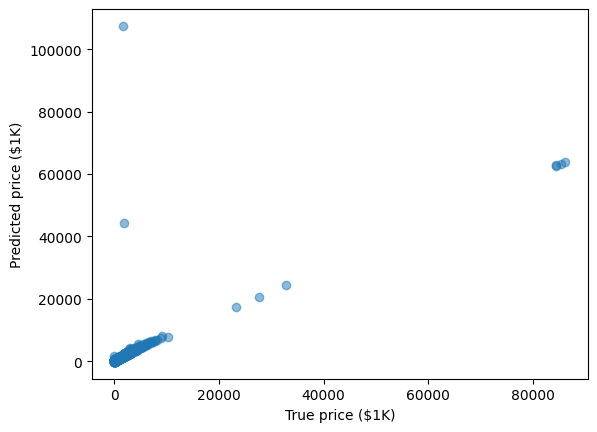

In [119]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

def train(X, y):
    model = LinearRegression().fit(X, y)
    return model

reg = train(X_train, y_train)

# c)
print(reg.score(X_test, y_test))
y_pred = reg.predict(X_test)

plt.scatter(y_test, y_pred, alpha=0.5)

# The model is somewhat accurate, which can be seen in the plot where
# the scatters is near the target line. The R^2 score is also
# about 0.6 which is decent. However, as about the remaining 40% is unexplained,
# there are other factors influencing the price.
# In the scatter plot it can also be seen that the model is more
# accurately prediciting the price for cheaper houses.

# Code provided by us to compare the generated predictions against the actual values
xlim = [0, 5]
ylim = [0, 5]
plt.plot(xlim, ylim, '--k')
plt.xlabel("True price ($1K)")
plt.ylabel("Predicted price ($1K)")
plt.show()

vendorid - Score: 22.51409
passenger_count - Score: 1.46341
p_distance - Score: 22.83274
ratecodeid - Score: 2.50393
store_and_fwd_flag - Score: -6.07834
pulocationid - Score: -0.01367
dolocationid - Score: -0.12028
payment_type - Score: 23.98026
fare_amount - Score: 13.06085
extra - Score: 11.96696
mta_tax - Score: 632.69972
tip_amount - Score: 15.32090
tolls_amount - Score: 10.16458
improvement_surcharge - Score: -359.23708
total_amount - Score: -9.28256
congestion_surcharge - Score: 27.17951
airport_fee - Score: -13.83593
tpep_pickup_year - Score: 2.90774
tpep_pickup_month - Score: -1950719.04930
tpep_pickup_day - Score: -63605.96704
tpep_pickup_hour - Score: -2656.11163
tpep_pickup_minute - Score: -44.39709
tpep_pickup_second - Score: -0.94830
tpep_dropoff_year - Score: 2.90774
tpep_dropoff_month - Score: 1950722.79732
tpep_dropoff_day - Score: 63606.15573
tpep_dropoff_hour - Score: 2657.48685
tpep_dropoff_minute - Score: 44.52075
tpep_dropoff_second - Score: 0.84068


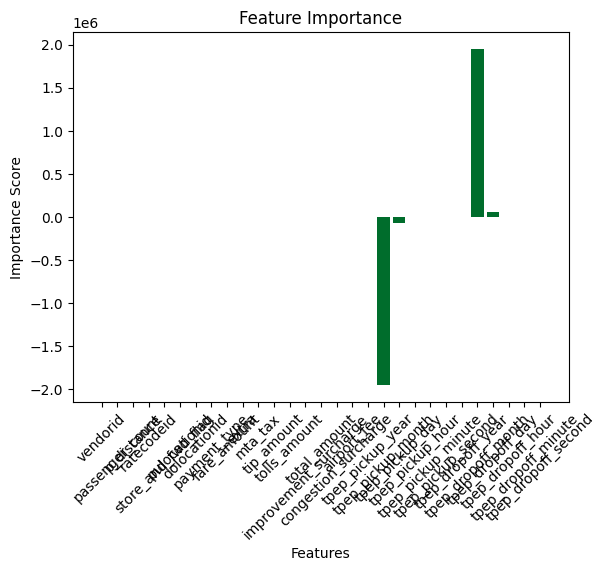

In [133]:
import matplotlib.pyplot as plt

importance = reg.coef_
feature_names = reg.feature_names_in_

# Summarize feature importance
for i, v in enumerate(importance):
    print(f'{feature_names[i]} - Score: {v:.5f}')

# Plot feature importance
plt.bar(range(len(importance)), importance, tick_label=feature_names)
plt.xticks(rotation=45)  # Rotate feature names for better readability
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importance")
plt.show()


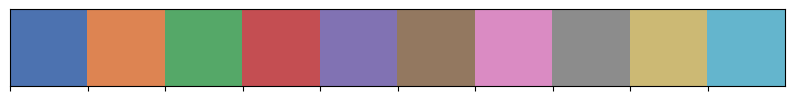

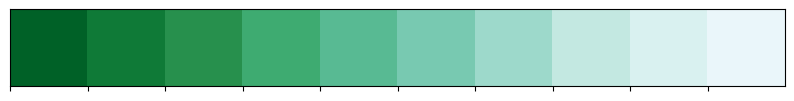

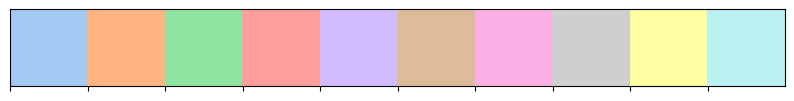

In [123]:
# We can choose different color schemes when plotting
import seaborn as sns
sns.palplot(sns.color_palette("deep"))
sns.palplot(sns.color_palette("BuGn_r", 10)) 
sns.palplot(sns.color_palette("pastel"))

# Set the color palette we want to use
sns.set_palette('BuGn_r', n_colors=7)

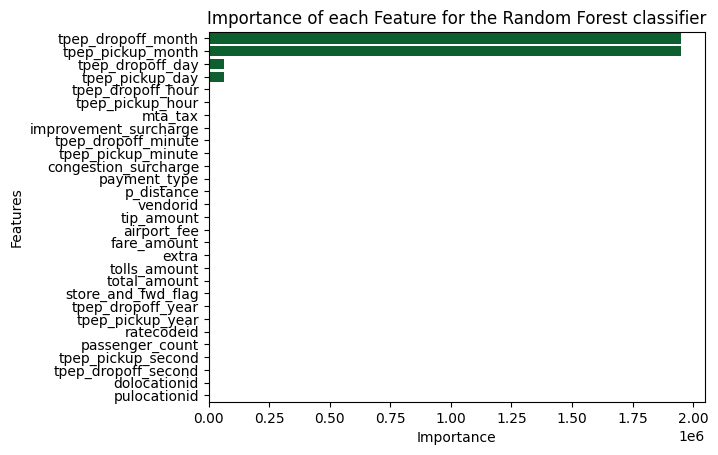

In [124]:
sns.barplot(x=feature_scores, y=feature_scores.index, )
plt.title("Importance of each Feature for the Random Forest classifier")
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()